# Gateset Tomography with Python and Q# #

## Preamble

In [1]:
import qsharp
import qsharp.experimental
qsharp.experimental.enable_noisy_simulation()

Preparing Q# environment...


In [2]:
import numpy as np
import qutip as qt
qt.settings.colorblind_safe = True
import pygsti as gst

## Intro to Gateset Tomography

TODO

## GST models

In pyGSTi, the concept of a _model_ is used to define the operatiuons that can be performed on a given device, the space of states that the device can be in, and what measurements are allowed on the device. In this notebook, we'll rely on one of the built-in models provided by pyGSTi, namely the `smq2Q_XYCNOT` model. This model is defined on two qubits, and represents devices with "X," "Y," and "CNOT" operations.

In [3]:
from pygsti.modelpacks import smq2Q_XYCNOT as gst_model

In [4]:
target_model = gst_model.target_model()

## Choosing and simulating GST experiments

The pyGSTi package can use models such as the one defined above to choose experiments that we can use to learn about the noise incurred by a quantum device. To do so, we can use the `make_lsgst_experiment_list` function:

In [5]:
max_lengths = [1, 2, 4]
experiments = gst.construction.make_lsgst_experiment_list(
    target_model,
    gst_model.prep_fiducials(),
    gst_model.meas_fiducials(),
    gst_model.germs(),
    max_lengths
)

Each of these experiments consists of running a nonadaptive quantum program (colloquially, a "circuit") a number of times and collecting the results.

In [6]:
experiments[:20]

[Circuit({}@(0,1)),
 Circuit(Gxpi2:1@(0,1)),
 Circuit(Gypi2:1@(0,1)),
 Circuit(Gxpi2:1Gxpi2:1@(0,1)),
 Circuit(Gxpi2:0@(0,1)),
 Circuit(Gypi2:0@(0,1)),
 Circuit(Gxpi2:0Gxpi2:0@(0,1)),
 Circuit(Gxpi2:0Gxpi2:1@(0,1)),
 Circuit(Gxpi2:0Gypi2:1@(0,1)),
 Circuit(Gypi2:0Gxpi2:1@(0,1)),
 Circuit(Gypi2:0Gypi2:1@(0,1)),
 Circuit(Gxpi2:0Gxpi2:1Gxpi2:1@(0,1)),
 Circuit(Gypi2:0Gxpi2:1Gxpi2:1@(0,1)),
 Circuit(Gxpi2:0Gxpi2:0Gxpi2:1@(0,1)),
 Circuit(Gxpi2:0Gxpi2:0Gypi2:1@(0,1)),
 Circuit(Gxpi2:0Gxpi2:0Gxpi2:1Gxpi2:1@(0,1)),
 Circuit(Gxpi2:1Gypi2:1@(0,1)),
 Circuit(Gxpi2:1Gxpi2:1Gxpi2:1@(0,1)),
 Circuit(Gxpi2:1Gxpi2:0@(0,1)),
 Circuit(Gxpi2:1Gypi2:0@(0,1))]

To run the GST procedure described by these experiments, we want to write a Q# operation that loops over each experiment and performs the prescribed measurements. We can do so by first focusing on running a single experiment at a time.

In pyGSTi notation, each such experiment is specified as a circuit that itself is comprised of a list of layers, with each layer consisting of a list of labeled gates. We want to turn this structure into a form that can be represented using basic Q# types. In particular, we can use a Python list comprehension to turn `experiments` into `(String, Int[])[][]`:

In [7]:
def experiments_as_qsharp_data(experiments):
    return [
        [
            (label.name, list(label.qubits))
            for idx_layer in range(experiment.depth())
            for label in experiment.get_layer(idx_layer)
        ]
        for experiment in experiments
    ]

In [8]:
experiments_as_qsharp_data(experiments)[:20]

[[],
 [('Gxpi2', [1])],
 [('Gypi2', [1])],
 [('Gxpi2', [1]), ('Gxpi2', [1])],
 [('Gxpi2', [0])],
 [('Gypi2', [0])],
 [('Gxpi2', [0]), ('Gxpi2', [0])],
 [('Gxpi2', [0]), ('Gxpi2', [1])],
 [('Gxpi2', [0]), ('Gypi2', [1])],
 [('Gypi2', [0]), ('Gxpi2', [1])],
 [('Gypi2', [0]), ('Gypi2', [1])],
 [('Gxpi2', [0]), ('Gxpi2', [1]), ('Gxpi2', [1])],
 [('Gypi2', [0]), ('Gxpi2', [1]), ('Gxpi2', [1])],
 [('Gxpi2', [0]), ('Gxpi2', [0]), ('Gxpi2', [1])],
 [('Gxpi2', [0]), ('Gxpi2', [0]), ('Gypi2', [1])],
 [('Gxpi2', [0]), ('Gxpi2', [0]), ('Gxpi2', [1]), ('Gxpi2', [1])],
 [('Gxpi2', [1]), ('Gypi2', [1])],
 [('Gxpi2', [1]), ('Gxpi2', [1]), ('Gxpi2', [1])],
 [('Gxpi2', [1]), ('Gxpi2', [0])],
 [('Gxpi2', [1]), ('Gypi2', [0])]]

Data of this type can then be easily passed directly to a Q# operation:

In [9]:
%%qsharp
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Measurement;

/// # Summary
/// Measures a single shot of a given GST sequence, returning out the result
/// for each qubit acted upon by the sequence.
///
/// # Input
/// ## sequence
/// An array describing each gate in the sequence, where the first item
/// of the tuple representing each gate is the name of the gate to be
/// performed as an operation, and where the second item is a list
/// of qubit indices. For example, `("Gxpi2", [0])` represents the
/// X operation acting on qubit 0.
operation MeasureGstSequence(sequence : (String, Int[])[]) : Result[] {
    use qs = Qubit[2];
    for (gate, qubits) in sequence {
        if gate == "Gxpi2" {
            X(qs[qubits[0]]);
        } elif gate == "Gypi2" {
            Y(qs[qubits[0]]);
        } elif gate == "Gcnot" {
            CNOT(qs[qubits[0]], qs[qubits[1]]);
        } else {
            fail $"Gate {gate} not recognized.";
        }
    }
    return ForEach(MResetZ, qs);
}

Once we have this operation, we can then loop over it to collect many shots of each sequence and to collect results for each different experiment.

In [10]:
%%qsharp
open Microsoft.Quantum.Convert;

operation RunGstExperiment(nShots : Int, sequence : (String, Int[])[]) : Int[] {
    mutable results = [0, size=4];
    for _ in 1..nShots {
        // NB: pyGSTi uses big-endian notation, so we need to reverse here.
        let idxResult = ResultArrayAsInt(Reversed(MeasureGstSequence(sequence)));
        set results w/= idxResult <- results[idxResult] + 1;
    }
    return results;
}

operation RunGstExperiments(nShots : Int, sequences : (String, Int[])[][]) : Int[][] {
    return ForEach(RunGstExperiment(nShots, _), sequences);
}

Since the only gates in the gateset used by our current model are `X`, `Y`, and `CNOT`, we would expect that when run without noise, all sequences return a definite result in the computational basis; we can confirm that by simulating our new `RunGstExperiments` operation without noise.

In [11]:
RunGstExperiments.simulate(
    nShots=20,
    sequences=experiments_as_qsharp_data(experiments)
)

[[20, 0, 0, 0],
 [0, 20, 0, 0],
 [0, 20, 0, 0],
 [20, 0, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [20, 0, 0, 0],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 20, 0, 0],
 [0, 20, 0, 0],
 [20, 0, 0, 0],
 [20, 0, 0, 0],
 [0, 20, 0, 0],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 20, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [20, 0, 0, 0],
 [20, 0, 0, 0],
 [0, 20, 0, 0],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 20, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 20, 0, 0],
 [20, 0, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [20, 0, 0, 0],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [0, 0, 0, 20],
 [20, 0, 0, 0],
 [0, 0, 20, 0],
 [0, 20, 0, 0],
 [0, 20, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 0, 20],
 [0, 20, 0, 0],
 [0, 20, 0, 0],
 [0, 0, 0, 20],
 [20, 0, 0, 0],
 [20, 0, 0, 0],
 [20, 0, 0, 0],
 [20, 0, 0, 0],
 [0, 0, 20, 0],
 [0, 0, 20, 0],
 [0, 0, 0, 20],
 [0, 20, 0, 0],
 [0, 20, 0, 0],
 [0, 0, 

## Noise models

Having tested that our operation returns something reasonable without noise, let's add noise and run again. After all, learning noise is the whole point of GST! So as to set a noise model that's somewhat physically motivated, we'll consider the _relaxation model_ originally first used to describe nuclear magnetic resonance (NMR).

In the relaxation model, noise is parameterized by two times, $T_1$ and $T_2$. Roughly, $T_1$ is the time it takes for qubit to relax to the $|0\rangle$ state by a factor of $e$, while $T_2$ is the time it takes for a superposition of states in the computational basis to decay to a mixture. In the Bloch sphere picture, we can think of $T_1$ as the sphere contracting towards the $|0\rangle$ pole, and $T_2$ as contracting towards the $Z$-axis.

To go from the relaxation model to channels that we can provide to the `qsharp.experimental` subpackage, we can represent relaxation using a technique known as _Lindblad form_. In particular, Lindblad form describes continuous-time noise in a quantum system as a derivative
$$
    \frac {\partial}{\partial t} \rho(t) = A\rho A^\dagger - \frac12 \{A^\dagger A, \rho\}
$$
where $A$ is a _Lindblad operator_, and where $\{A, B\} = AB + BA$ is the _anticommutator_.

The Lindblad operators for relaxation noise are $1 / \sqrt{T_1} \sigma_-$ and $1 / \sqrt{2 T_{2,\text{eff}}} Z$, where $1 / T_{2,\text{eff}} = 1 / T_2 - 1 / (2T_1)$. Substituting these in to the equation above, we can find the superoperator representation of the contributions to the time derivative of $\rho$ stemming from noise.

Using the column stacking convention that $|ABC⟫ = C^T \otimes A |B⟫$, we can factor out $|\rho⟫$ to get the resulting superoperator:
$$
\begin{aligned}
    \mathcal{D}[A] & = (A^\dagger)^T \otimes A - \frac12 (A^\dagger A)^T \otimes 𝟙 - \frac12 𝟙 \otimes (A^\dagger A) \\
                   & = A^* \otimes A - \frac12 A^T A^* \otimes 𝟙 - \frac12 𝟙 \otimes A^\dagger A.
\end{aligned}
$$

If the quantum device also evolves under a Hamiltonian $H$ at the same time, then the total derivative is given by the von Neumann equation (the Schrödinger equation expressed in terms of density operators) plus the dissipative term above:
$$
    \frac{d}{dt} \rho = -i [H, \rho] + \sum_i \mathcal{D}[A_i](\rho).
$$

Just as we represented $\mathcal{D}[A_i]$ as a superoperator, we can represent the commutator $[H, \cdot]$ as a superoperator known as the _Liouvillian_:
$$
    L = 𝟙 \otimes H - H^T \otimes 𝟙.
$$

Thus, we have that our channel is given by solving the differential equation $\dot\rho = (-iL + \sum_i \mathcal{D}[A_i]) \rho$. This equation is solved by the matrix exponential, giving us that
$$
    \Lambda = \exp\left((-iL + \sum_i \mathcal{D}[A_i]) t\right).
$$

Using QuTiP to calculate this, we can find a channel for arbitrary gate times, $T_1$, $T_2$, and Liouvillians. In doing so, we will assume the unitary $U$ we would like to implement is given in terms of a Hamiltonian $\tilde{H}$ rescaled to a gate time of $1$, so that the actual Hamiltonian is given by $H = \tilde{H} / \tau$ where $\tau$ is the time required to run the given gate, and where $U = e^{i\tilde{H}} = e^{i\tau H}$.

In [12]:
def dissipator(lindblad_op, coeff=1.0):
    A = lindblad_op
    AdA = A.dag() * A
    d_out, d_in = A.dims
    I = qt.qeye(d_in)
    D = coeff * (qt.tensor(A.conj(), A) - (0.5) * (qt.tensor(AdA.trans(), I) + qt.tensor(I, AdA)))
    # set dims to super
    D.dims = [[d_in, d_out], [d_in, d_out]]
    return D

In [13]:
from qutip.qip.gates import expand_operator

C:\Users\cgran\AppData\Local\Temp/ipykernel_113916/2208000655.py:1: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import expand_operator


In [14]:
def relaxation_noise(n_qubits: int, adj_U: qt.Qobj, gate_time: float, t1: float, t2: float) -> qt.Qobj:
    t2_eff = 1 / (1 / t2 - 0.5 * 1 / t1)
    
    # Add noise on each qubit independently.
    D = sum(
        dissipator(expand_operator(qt.destroy(2), n_qubits, [idx_qubit]), 1 / t1) +
        dissipator(expand_operator(qt.sigmaz(), n_qubits, [idx_qubit]), 1 / (2 * t2_eff))
        for idx_qubit in range(n_qubits)
    )
    angle = np.pi / 2
    H = adj_U / gate_time
    I = qt.qeye([2] * n_qubits)
    L = qt.tensor(I, H) - qt.tensor(H.trans(), I)
    L.dims = D.dims
    return (gate_time * (-1j * L + D)).expm()

For example, if we want to implement an `X` operation that takes 2µs on a system where $T_1 = T_2 = 100 \text{µs}$, we can find a channel that describes the effect of this relaxation on our operation:

In [15]:
S = relaxation_noise(1, qt.sigmax() * np.pi / 2, 2.0, 100.0, 100.0)
S

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[0.00994079+0.j         0.        +0.j         0.        +0.j
  0.99013946+0.j        ]
 [0.        -0.00630291j 0.        +0.j         0.98019867+0.j
  0.        -0.00630291j]
 [0.        +0.00630291j 0.98019867+0.j         0.        +0.j
  0.        +0.00630291j]
 [0.99005921+0.j         0.        +0.j         0.        +0.j
  0.00986054+0.j        ]]

As expected, the resulting channel is nearly an ideal `X` operation, and flips the sign of 𝑌 and 𝑍.

(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

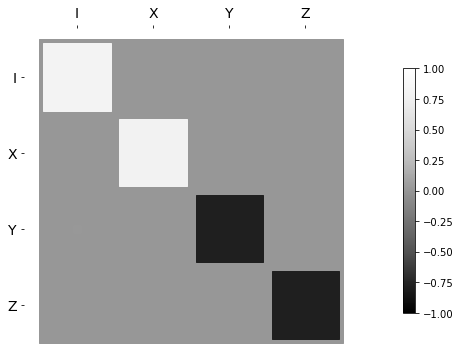

In [16]:
qt.visualization.hinton(S)

The same approach works for multi-qubit noise as well:

C:\Users\cgran\AppData\Local\Temp/ipykernel_113916/4061253388.py:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  qt.visualization.hinton(relaxation_noise(2, qt.cnot(2, 0, 1) * np.pi / 2, 15.0, 100.0, 100.0))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

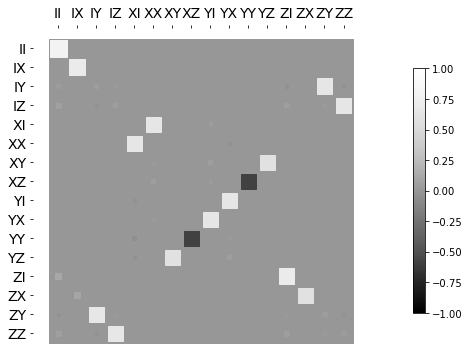

In [17]:
qt.visualization.hinton(relaxation_noise(2, qt.cnot(2, 0, 1) * np.pi / 2, 15.0, 100.0, 100.0))

In [18]:
noise_model = qsharp.experimental.get_noise_model_by_name('ideal')
noise_model['x'] = relaxation_noise(1, qt.sigmax() * np.pi / 2, 2.0, 100.0, 100.0)
noise_model['y'] = relaxation_noise(1, qt.sigmay() * np.pi / 2, 2.5, 100.0, 100.0)
noise_model['cnot'] = relaxation_noise(2, qt.cnot() * np.pi / 2, 10.0, 100.0, 100.0)
qsharp.experimental.set_noise_model(noise_model)

C:\Users\cgran\AppData\Local\Temp/ipykernel_113916/758387841.py:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  noise_model['cnot'] = relaxation_noise(2, qt.cnot() * np.pi / 2, 10.0, 100.0, 100.0)


With our relaxation noise built into the noise model used by the open systems simulator, we can now run our GST experiments again:

In [19]:
noisy_results = RunGstExperiments.simulate_noise(
    nShots=200,
    sequences=experiments_as_qsharp_data(experiments)
)

With our noisy results in hand, we use pyGSTi to infer the actual gateset from our GST data. Using more accurate inference methods can be fairly slow, so we'll use linear-inversion GST in this notebook for the sake of brevity.

In [20]:
outcome_labels = ['00', '01', '10', '11']
ds = gst.objects.DataSet(outcomeLabels=outcome_labels)

In [22]:
for circuit, result in zip(experiments, noisy_results):
    ds.add_count_dict(circuit, {
        label: outcome
        for label, outcome in zip(outcome_labels, result)
    })

In [23]:
est_model = gst.do_lgst(
    ds,
    gst_model.prep_fiducials(),
    gst_model.meas_fiducials(),
    target_model
)

In [24]:
print(est_model.operations[("Gxpi2", 0)].todense())

[[ 9.99983105e-01 -1.89210331e-05  1.84434637e-05 -1.85984505e-06
   2.85627826e-05 -6.11920748e-05  1.30245116e-04 -2.19720688e-05
  -1.11100001e-05  5.09572262e-05  4.14167637e-06 -7.64464220e-06
   1.81379529e-05 -2.29691348e-05  7.92533544e-06  6.16689433e-07]
 [-1.37688871e-02  4.20939365e-01 -9.94032384e-01 -1.28450642e-01
  -6.99727415e-01  5.89304979e-01 -2.43752664e-01  9.52475029e-02
  -3.40639566e-01  6.85344358e-01 -1.09382783e+00  1.98420037e-01
   1.06116013e-01  1.91519777e-01  3.70323722e-01  3.61035158e-02]
 [-1.12667494e-02 -5.76336562e-01  6.03488704e-04 -1.24046159e-01
  -7.01362219e-01  6.05880796e-01 -2.28531673e-01  1.03825881e-01
  -3.27559082e-01  6.85129998e-01 -1.07017156e+00  1.92246173e-01
   1.04597362e-01  1.95754838e-01  3.72875928e-01  3.07155463e-02]
 [-2.31858122e-01  2.48200046e-01  1.03518423e-01  5.75748370e-01
   3.71308994e-01 -1.96683519e+00 -3.81243458e-01 -9.01915250e-01
  -1.13273263e+00  1.23732107e+00 -2.40369109e+00  4.76622879e-01
   8.02